In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import KMeansSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.impute import SimpleImputer

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


train_data = pd.read_csv('./input/train_data.csv')
test_data = pd.read_csv('./input/test_data.csv')

train_data.columns = train_data.columns.str.strip().str.replace(' ', '_')
test_data.columns = test_data.columns.str.strip().str.replace(' ', '_')

./input/train_data.csv
./input/test_data.csv
./input/sample_submission.csv


In [3]:
train_data['is_train'] = 1
test_data['is_train'] = 0
combined_data = pd.concat([train_data, test_data], ignore_index=True)
combined_data.head()

,ID,TARGET,Limit_balance,Sex,Education,Marriage,Age,Pay_1,Pay_2,Pay_3,Pay_4,Pay_5,Pay_6,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,Pay_amt1,Pay_amt2,Pay_amt3,Pay_amt4,Pay_amt5,Pay_amt6,City,State,Credit_tier,Bureau_score,Date_account_opened,Tenure_years,Credit_utilisation_ratio,Average_payment_delay,Total_payments,Total_bill_amount,Payment_consistency,Age_group,is_train
0,1,1.0,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,Phoenix,TX,Basic,688,2017/07/22,6,0.14,0.50,5000,17077,753,Young,1
1,2,0.0,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,Chicago,NY,Gold,482,2019/01/08,5,1.13,0.00,11018,101653,1570,Middle-aged,1
2,3,0.0,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,Phoenix,AZ,Gold,560,2017/01/03,7,2.19,-0.33,59049,109339,13786,Senior,1
3,4,0.0,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,Phoenix,AZ,Platinum,376,2021/02/08,3,4.76,0.00,7772,238114,714,Middle-aged,1
4,5,0.0,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,Phoenix,NY,Platinum,497,2017/01/08,7,5.45,0.00,180759,2724595,16803,Young,1


In [4]:
combined_data.columns

Index(['ID', 'TARGET', 'Limit_balance', 'Sex', 'Education', 'Marriage', 'Age',
       'Pay_1', 'Pay_2', 'Pay_3', 'Pay_4', 'Pay_5', 'Pay_6', 'Bill_amt1',
       'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6',
       'Pay_amt1', 'Pay_amt2', 'Pay_amt3', 'Pay_amt4', 'Pay_amt5', 'Pay_amt6',
       'City', 'State', 'Credit_tier', 'Bureau_score', 'Date_account_opened',
       'Tenure_years', 'Credit_utilisation_ratio', 'Average_payment_delay',
       'Total_payments', 'Total_bill_amount', 'Payment_consistency',
       'Age_group', 'is_train'],
      dtype='object')

In [5]:
# drop_columns = ['City', 'State', 'Credit_tier', 'Bureau_score', 'Date_account_opened','Tenure_years', 'Credit_utilisation_ratio', 
#                 'Average_payment_delay','Total_payments', 'Total_bill_amount', 'Payment_consistency', 'Age_group']
drop_columns = ['City', 'State', 'Date_account_opened']
combined_data.drop(columns=drop_columns, inplace=True)

In [6]:
combined_data.isnull().sum()

ID                              0
TARGET                      16629
Limit_balance                   0
Sex                             0
Education                       0
Marriage                        0
Age                             0
Pay_1                           0
Pay_2                           0
Pay_3                           0
Pay_4                           0
Pay_5                           0
Pay_6                           0
Bill_amt1                       0
Bill_amt2                       0
Bill_amt3                       0
Bill_amt4                       0
Bill_amt5                       0
Bill_amt6                       0
Pay_amt1                        0
Pay_amt2                        0
Pay_amt3                        0
Pay_amt4                        0
Pay_amt5                        0
Pay_amt6                        0
Credit_tier                     0
Bureau_score                    0
Tenure_years                    0
Credit_utilisation_ratio        0
Average_paymen

In [7]:
combined_data.head()

,ID,TARGET,Limit_balance,Sex,Education,Marriage,Age,Pay_1,Pay_2,Pay_3,Pay_4,Pay_5,Pay_6,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,Pay_amt1,Pay_amt2,Pay_amt3,Pay_amt4,Pay_amt5,Pay_amt6,Credit_tier,Bureau_score,Tenure_years,Credit_utilisation_ratio,Average_payment_delay,Total_payments,Total_bill_amount,Payment_consistency,Age_group,is_train
0,1,1.0,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,Basic,688,6,0.14,0.50,5000,17077,753,Young,1
1,2,0.0,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,Gold,482,5,1.13,0.00,11018,101653,1570,Middle-aged,1
2,3,0.0,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,Gold,560,7,2.19,-0.33,59049,109339,13786,Senior,1
3,4,0.0,50000,1,1,2,37,0,0,0,0,0,0,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,Platinum,376,3,4.76,0.00,7772,238114,714,Middle-aged,1
4,5,0.0,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,Platinum,497,7,5.45,0.00,180759,2724595,16803,Young,1


In [8]:
numerical_columns = ['Limit_balance', 'Age', 'Pay_1', 'Pay_2', 'Pay_3', 'Pay_4', 'Pay_5', 'Pay_6', 
                     'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 
                     'Pay_amt1', 'Pay_amt2', 'Pay_amt3', 'Pay_amt4', 'Pay_amt5', 'Pay_amt6',
                     'Bureau_score', 'Tenure_years', 'Credit_utilisation_ratio', 
                     'Average_payment_delay', 'Total_payments', 'Total_bill_amount', 'Payment_consistency']

# continuous_columns = ['Limit_balance', 'Age', 'Pay_1', 'Pay_2', 'Pay_3', 'Pay_4', 'Pay_5', 'Pay_6',
#                        'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6',
#                        'Pay_amt1', 'Pay_amt2', 'Pay_amt3', 'Pay_amt4', 'Pay_amt5', 'Pay_amt6', 'Bureau_score',
#                        'Credit_utilisation_ratio', 'Average_payment_delay', 'Total_payments', 'Total_bill_amount',
#                        'Payment_consistency', 'Tenure_years']

categorical_columns = ['Sex', 'Education', 'Marriage', 'Credit_tier', 'Age_group']

for col in numerical_columns:
    combined_data[col] = combined_data[col].replace(' -   ', np.nan).astype(float)
    
# Ensure numerical columns are converted to numeric types and handle NaNs
for col in numerical_columns:
    if col in combined_data.columns:
        train_data[col] = pd.to_numeric(train_data[col], errors='coerce').fillna(0)  # Fill NaNs with 0 or appropriate value


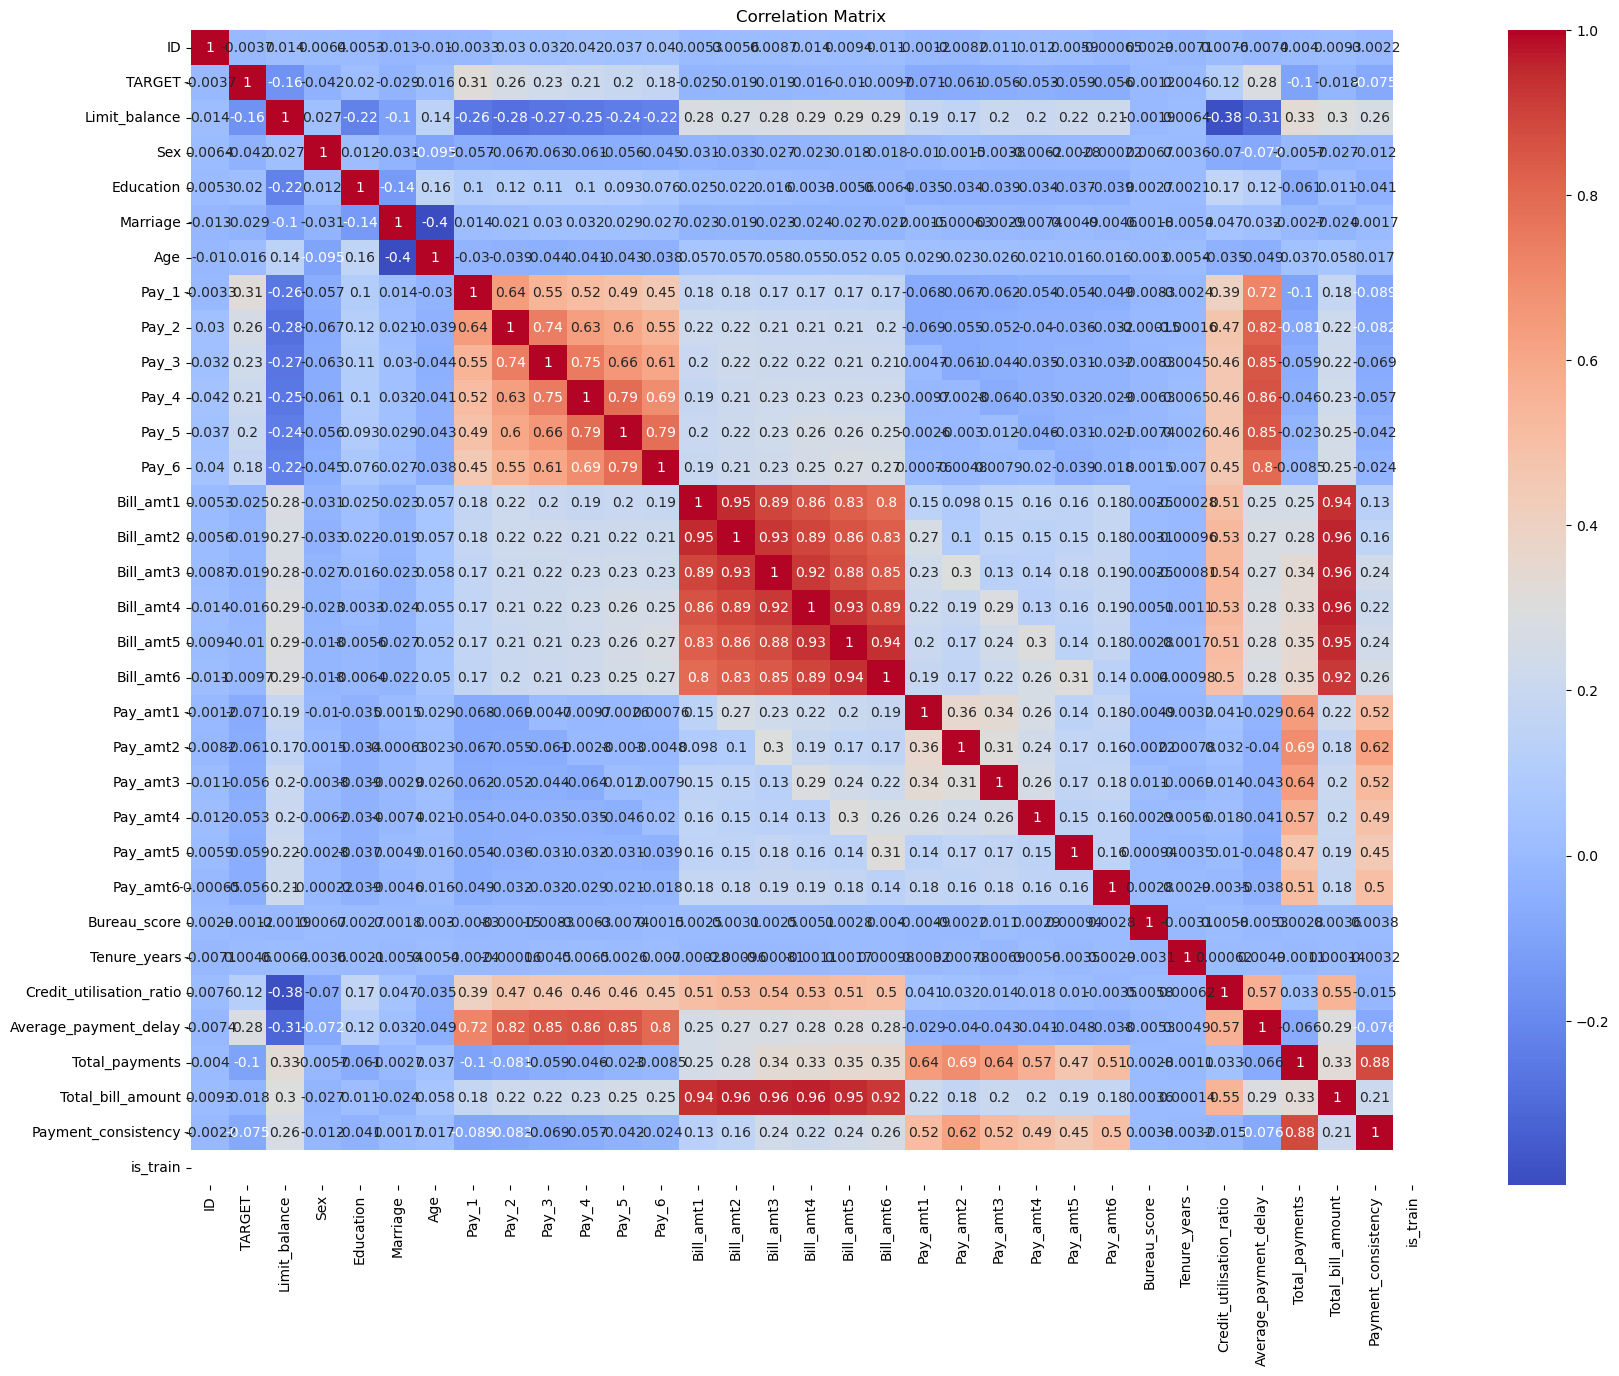

In [9]:
# for feature in numerical_columns:
#     plt.figure(figsize=(10, 6))
#     sns.histplot(combined_data[feature], kde=True)
#     plt.title(f'Distribution of {feature}')
#     plt.show()

# Correlation matrix
plt.figure(figsize=(20, 15))
correlation_matrix = train_data.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [10]:
# pearson correlation coefficients
correlation_matrix = train_data[numerical_columns + ['TARGET']].corr()
correlation_with_target = correlation_matrix['TARGET'].sort_values(ascending=False)
print(correlation_with_target)

TARGET                      1.000000
Pay_1                       0.311566
Average_payment_delay       0.281997
Pay_2                       0.256977
Pay_3                       0.230623
Pay_4                       0.208789
Pay_5                       0.195420
Pay_6                       0.175794
Credit_utilisation_ratio    0.117971
Age                         0.016121
Tenure_years                0.004618
Bureau_score               -0.001210
Bill_amt6                  -0.009718
Bill_amt5                  -0.010212
Bill_amt4                  -0.015751
Total_bill_amount          -0.017888
Bill_amt3                  -0.018792
Bill_amt2                  -0.019183
Bill_amt1                  -0.025375
Pay_amt4                   -0.053418
Pay_amt6                   -0.055945
Pay_amt3                   -0.056245
Pay_amt5                   -0.058678
Pay_amt2                   -0.061074
Pay_amt1                   -0.070755
Payment_consistency        -0.075496
Total_payments             -0.100024
L

In [11]:
anova_results = {}
for feature in numerical_columns:
    groups = [train_data[train_data['TARGET'] == value][feature] for value in train_data['TARGET'].unique()]
    f_stat, p_val = f_oneway(*groups)
    anova_results[feature] = p_val

print(anova_results)

{'Limit_balance': 5.759888435135759e-194, 'Age': 0.0032285254419335114, 'Pay_1': 0.0, 'Pay_2': 0.0, 'Pay_3': 0.0, 'Pay_4': 0.0, 'Pay_5': 1.6190891512489093e-284, 'Pay_6': 8.603662734865324e-230, 'Bill_amt1': 3.5511433356688117e-06, 'Bill_amt2': 0.0004573451032384271, 'Bill_amt3': 0.000596937087782685, 'Bill_amt4': 0.0040103166236897195, 'Bill_amt5': 0.062103811024087914, 'Bill_amt6': 0.07585174835825666, 'Pay_amt1': 2.6407619353019487e-38, 'Pay_amt2': 5.923120990206973e-29, 'Pay_amt3': 8.457770667835124e-25, 'Pay_amt4': 1.5939788088544025e-22, 'Pay_amt5': 7.517740334596585e-27, 'Pay_amt6': 1.4926811221620445e-24, 'Bureau_score': 0.8251059344562448, 'Tenure_years': 0.39891320940001407, 'Credit_utilisation_ratio': 1.0367107022086285e-103, 'Average_payment_delay': 0.0, 'Total_payments': 6.009875109624866e-75, 'Total_bill_amount': 0.0010835093775279966, 'Payment_consistency': 2.197890782907512e-43}


In [12]:
# Chi-Square test
chi_square_results = {}
for feature in categorical_columns:
    contingency_table = pd.crosstab(train_data[feature], train_data['TARGET'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[feature] = p

print(chi_square_results)

{'Sex': 2.2821862723724812e-14, 'Education': 6.679535441600297e-37, 'Marriage': 6.833145658531588e-09, 'Credit_tier': 0.4595650932690343, 'Age_group': 1.986270906726974e-06}


In [13]:
# Map pay values to get rid of negatives first
# def map_pay_values(value):
#     if value < 0:
#         return 'on_time'
#     elif value == 0:
#         return 'no_delay'
#     elif value == 1:
#         return '1_month_delay'
#     elif value == 2:
#         return '2_month_delay'
#     elif value == 3:
#         return '3_month_delay'
#     elif value == 4:
#         return '4_month_delay'
#     elif value == 5:
#         return '5_month_delay'
#     elif value == 6:
#         return '6_month_delay'
#     elif value == 7:
#         return '7_month_delay'
#     elif value == 8:
#         return '8_month_delay'
#     elif value == 9:
#         return '9_or_more_month_delay'
#     else:
#         return 'unknown'

# pay_columns = ['Pay_1', 'Pay_2', 'Pay_3', 'Pay_4', 'Pay_5', 'Pay_6']

# for col in pay_columns:
#     if col not in combined_data.columns:
#         combined_data[col] = pd.Series([None]*len(train_data))

# for col in pay_columns:
#     combined_data[col] = combined_data[col].astype(int).apply(map_pay_values)


# print(combined_data[pay_columns].isna().sum())

# # # Ordinal Encoding
# # categories = [['on_time', 'paid_duly', 'no_delay', '1_month_delay', '2_month_delay', '3_month_delay', '4_month_delay', '5_month_delay', '6_month_delay', '7_month_delay', '8_month_delay', '9_or_more_month_delay']]
# # ordinal_encoder = OrdinalEncoder(categories=categories)

# # for col in pay_columns:
# #    combined_data[col] = ordinal_encoder.fit_transform(combined_data[[col]])


# combined_data.head()

In [14]:
# Log transformation
# Replace zero values with a small positive number before log transformation
def replace_zeros(series):
    return series.replace(0, 1e-9)

log_transform_columns = ['Limit_balance', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'Pay_amt1', 'Pay_amt2',
                         'Pay_amt3', 'Pay_amt4', 'Pay_amt5', 'Pay_amt6', 'Credit_utilisation_ratio', 'Total_payments', 'Total_bill_amount', 'Payment_consistency']

for col in log_transform_columns:
    combined_data[col] = replace_zeros(combined_data[col])
    combined_data[col] = np.log1p(combined_data[col])

# Handle outliers by capping
def cap_outliers(series):
    lower_bound = series.quantile(0.01)
    upper_bound = series.quantile(0.99)
    return series.clip(lower=lower_bound, upper=upper_bound)

cap_columns = ['Age', 'Tenure_years', 'Bureau_score', 'Limit_balance', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6',
               'Pay_amt1', 'Pay_amt2', 'Pay_amt3', 'Pay_amt4', 'Pay_amt5', 'Pay_amt6', 'Credit_utilisation_ratio', 'Total_payments', 'Total_bill_amount', 'Payment_consistency']

for col in cap_columns:
    combined_data[col] = cap_outliers(combined_data[col])

# Standard scaling for continuous variables
scaler = MinMaxScaler()
scaled_columns = ['Limit_balance', 'Age', 'Pay_1', 'Pay_2',	'Pay_3', 'Pay_4','Pay_5', 'Pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 
                  'Bill_amt5', 'Bureau_score', 'Tenure_years', 'Average_payment_delay',
                  'Bill_amt6', 'Pay_amt1', 'Pay_amt2', 'Pay_amt3', 'Pay_amt4', 'Pay_amt5', 'Pay_amt6', 'Credit_utilisation_ratio', 'Total_payments', 'Total_bill_amount', 'Payment_consistency']

combined_data[scaled_columns] = scaler.fit_transform(combined_data[scaled_columns])

In [15]:
fil = (combined_data['Education'] == 0) | (combined_data['Education'] == 5) | (combined_data['Education'] == 6) | (combined_data['Education'] == 4)
combined_data.loc[fil, 'Education'] = 'Others'

#Value counts for marriage category
fil_marriage = combined_data['Marriage']==0
combined_data.loc[fil_marriage,'Marriage'] = 'Others'

combined_data.replace({'Sex': {1 : 'Male', 2 : 'Female'}}, inplace=True)
combined_data.replace({'Education' : {1 : 'Graduate School', 2 : 'University', 3 : 'High School', 4 : 'Others'}}, inplace=True)
combined_data.replace({'Marriage' : {1 : 'Married', 2 : 'Single', 3 : 'Others'}}, inplace = True)
combined_data.replace({'TARGET' : {1 : 'Yes', 0 : 'No'}}, inplace = True)
combined_data.head()

,ID,TARGET,Limit_balance,Sex,Education,Marriage,Age,Pay_1,Pay_2,Pay_3,Pay_4,Pay_5,Pay_6,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,Pay_amt1,Pay_amt2,Pay_amt3,Pay_amt4,Pay_amt5,Pay_amt6,Credit_tier,Bureau_score,Tenure_years,Credit_utilisation_ratio,Average_payment_delay,Total_payments,Total_bill_amount,Payment_consistency,Age_group,is_train
0,1,Yes,0.628885,Female,University,Single,0.125,0.1,0.4,0.2,0.181818,0.2,0.4,0.618610,0.585895,0.622060,0.640911,0.648623,0.645242,0.000000,0.616606,0.621132,0.620646,0.000000,0.670099,Basic,0.709259,0.625,0.064190,0.333333,0.682186,0.676626,0.593192,Young,1
1,2,No,0.556076,Female,University,Single,0.325,0.2,0.2,0.2,0.181818,0.2,0.2,0.805776,0.750594,0.749723,0.757856,0.765210,0.769800,0.661045,0.652764,0.621132,0.620646,0.622988,0.750848,Gold,0.327778,0.500,0.370417,0.272727,0.745458,0.800473,0.658916,Middle-aged,1
2,3,No,0.407314,Male,University,Married,0.900,0.1,0.2,0.1,0.181818,0.2,0.2,0.710047,0.679401,0.826298,0.787885,0.784913,0.786334,0.685913,0.938021,0.828066,0.817954,0.589438,0.574953,Gold,0.472222,0.750,0.568283,0.232727,0.879916,0.805533,0.853383,Senior,1
3,4,No,0.407314,Male,Graduate School,Single,0.400,0.2,0.2,0.2,0.181818,0.2,0.2,0.867646,0.860895,0.863704,0.781812,0.786855,0.789973,0.706039,0.669766,0.583413,0.620646,0.622988,0.589390,Platinum,0.131481,0.250,0.857768,0.272727,0.717509,0.859569,0.588437,Middle-aged,1
4,5,No,0.990074,Male,Graduate School,Single,0.200,0.2,0.2,0.2,0.181818,0.2,0.2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984925,0.945751,0.948083,0.890749,0.859254,0.840142,Platinum,0.355556,0.750,0.913195,0.272727,0.969523,1.000000,0.871101,Young,1


Text(0.5, 1.0, 'Loan Default Distribution')

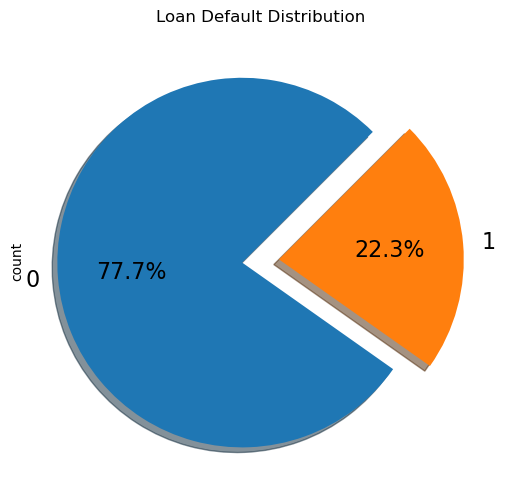

In [16]:
 
plt.figure(figsize=(6, 6))

train_data['TARGET'].value_counts().plot.pie(
    explode=[0.1, 0.1], 
    autopct='%1.1f%%', 
    shadow=True, 
    textprops={'fontsize': 16}, 
    startangle=45
    ).set_title("Loan Default Distribution")

In [17]:
label_encoder = LabelEncoder()
label_encoded_cols = ['Age_group', 'Credit_tier']
for col in label_encoded_cols:
    print(col)
    combined_data[col] = label_encoder.fit_transform(combined_data[col])


# new_categorical_features = ['Sex', 'Education', 'Marriage', 'Age_group']
categorical_one_hot_encode = ['Sex', 'Education', 'Marriage']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(combined_data[categorical_one_hot_encode])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_one_hot_encode))
combined_data = pd.concat([combined_data, encoded_df], axis=1)
combined_data.drop(columns=categorical_one_hot_encode, inplace=True)    

Age_group
Credit_tier


In [18]:
combined_data.head()

,ID,TARGET,Limit_balance,Age,Pay_1,Pay_2,Pay_3,Pay_4,Pay_5,Pay_6,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,Pay_amt1,Pay_amt2,Pay_amt3,Pay_amt4,Pay_amt5,Pay_amt6,Credit_tier,Bureau_score,Tenure_years,Credit_utilisation_ratio,Average_payment_delay,Total_payments,Total_bill_amount,Payment_consistency,Age_group,is_train,Sex_Female,Sex_Male,Education_Graduate School,Education_High School,Education_Others,Education_University,Marriage_Married,Marriage_Others,Marriage_Single
0,1,Yes,0.628885,0.125,0.1,0.4,0.2,0.181818,0.2,0.4,0.618610,0.585895,0.622060,0.640911,0.648623,0.645242,0.000000,0.616606,0.621132,0.620646,0.000000,0.670099,0,0.709259,0.625,0.064190,0.333333,0.682186,0.676626,0.593192,2,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2,No,0.556076,0.325,0.2,0.2,0.2,0.181818,0.2,0.2,0.805776,0.750594,0.749723,0.757856,0.765210,0.769800,0.661045,0.652764,0.621132,0.620646,0.622988,0.750848,1,0.327778,0.500,0.370417,0.272727,0.745458,0.800473,0.658916,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,3,No,0.407314,0.900,0.1,0.2,0.1,0.181818,0.2,0.2,0.710047,0.679401,0.826298,0.787885,0.784913,0.786334,0.685913,0.938021,0.828066,0.817954,0.589438,0.574953,1,0.472222,0.750,0.568283,0.232727,0.879916,0.805533,0.853383,1,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,4,No,0.407314,0.400,0.2,0.2,0.2,0.181818,0.2,0.2,0.867646,0.860895,0.863704,0.781812,0.786855,0.789973,0.706039,0.669766,0.583413,0.620646,0.622988,0.589390,2,0.131481,0.250,0.857768,0.272727,0.717509,0.859569,0.588437,0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,No,0.990074,0.200,0.2,0.2,0.2,0.181818,0.2,0.2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984925,0.945751,0.948083,0.890749,0.859254,0.840142,2,0.355556,0.750,0.913195,0.272727,0.969523,1.000000,0.871101,2,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
combined_data.columns

Index(['ID', 'TARGET', 'Limit_balance', 'Age', 'Pay_1', 'Pay_2', 'Pay_3',
       'Pay_4', 'Pay_5', 'Pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3',
       'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'Pay_amt1', 'Pay_amt2',
       'Pay_amt3', 'Pay_amt4', 'Pay_amt5', 'Pay_amt6', 'Credit_tier',
       'Bureau_score', 'Tenure_years', 'Credit_utilisation_ratio',
       'Average_payment_delay', 'Total_payments', 'Total_bill_amount',
       'Payment_consistency', 'Age_group', 'is_train', 'Sex_Female',
       'Sex_Male', 'Education_Graduate School', 'Education_High School',
       'Education_Others', 'Education_University', 'Marriage_Married',
       'Marriage_Others', 'Marriage_Single'],
      dtype='object')

In [20]:
encode_target = {"TARGET":{"Yes":1,"No":0}} # Fix for target back to default
combined_data=combined_data.replace(encode_target)

combined_data.head()

,ID,TARGET,Limit_balance,Age,Pay_1,Pay_2,Pay_3,Pay_4,Pay_5,Pay_6,Bill_amt1,Bill_amt2,Bill_amt3,Bill_amt4,Bill_amt5,Bill_amt6,Pay_amt1,Pay_amt2,Pay_amt3,Pay_amt4,Pay_amt5,Pay_amt6,Credit_tier,Bureau_score,Tenure_years,Credit_utilisation_ratio,Average_payment_delay,Total_payments,Total_bill_amount,Payment_consistency,Age_group,is_train,Sex_Female,Sex_Male,Education_Graduate School,Education_High School,Education_Others,Education_University,Marriage_Married,Marriage_Others,Marriage_Single
0,1,1.0,0.628885,0.125,0.1,0.4,0.2,0.181818,0.2,0.4,0.618610,0.585895,0.622060,0.640911,0.648623,0.645242,0.000000,0.616606,0.621132,0.620646,0.000000,0.670099,0,0.709259,0.625,0.064190,0.333333,0.682186,0.676626,0.593192,2,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2,0.0,0.556076,0.325,0.2,0.2,0.2,0.181818,0.2,0.2,0.805776,0.750594,0.749723,0.757856,0.765210,0.769800,0.661045,0.652764,0.621132,0.620646,0.622988,0.750848,1,0.327778,0.500,0.370417,0.272727,0.745458,0.800473,0.658916,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,3,0.0,0.407314,0.900,0.1,0.2,0.1,0.181818,0.2,0.2,0.710047,0.679401,0.826298,0.787885,0.784913,0.786334,0.685913,0.938021,0.828066,0.817954,0.589438,0.574953,1,0.472222,0.750,0.568283,0.232727,0.879916,0.805533,0.853383,1,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,4,0.0,0.407314,0.400,0.2,0.2,0.2,0.181818,0.2,0.2,0.867646,0.860895,0.863704,0.781812,0.786855,0.789973,0.706039,0.669766,0.583413,0.620646,0.622988,0.589390,2,0.131481,0.250,0.857768,0.272727,0.717509,0.859569,0.588437,0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,0.0,0.990074,0.200,0.2,0.2,0.2,0.181818,0.2,0.2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984925,0.945751,0.948083,0.890749,0.859254,0.840142,2,0.355556,0.750,0.913195,0.272727,0.969523,1.000000,0.871101,2,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
# From pcc and anova  and chi above
core_features = ['Pay_1', 'Pay_2', 'Pay_3', 'Pay_4', 'Pay_5', 'Pay_6', 'Average_payment_delay', 'Credit_utilisation_ratio', 'is_train', 'ID', 'TARGET']
core_financial_features = core_features + ['Limit_balance', 'Total_payments', 'Payment_consistency']
core_payment_features = core_features + ['Pay_amt1', 'Pay_amt2', 'Pay_amt3', 'Pay_amt4', 'Pay_amt5', 'Pay_amt6']
all_important_features = core_features + [
    'Limit_balance', 'Total_payments', 'Payment_consistency',
    'Pay_amt1', 'Pay_amt2', 'Pay_amt3', 'Pay_amt4', 'Pay_amt5', 'Pay_amt6',
    'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Total_bill_amount',
    'Age'
]

all_important_features_minus_bill = core_features + [
    'Limit_balance', 'Total_payments', 'Payment_consistency',
    'Pay_amt1', 'Pay_amt2', 'Pay_amt3', 'Pay_amt4', 'Pay_amt5', 'Pay_amt6', 'Age'
]

categorical_features = ['Sex', 'Education', 'Marriage', 'Age_group']
new_categorical_features = ['Sex_Female', 'Sex_Male', 'Education_Graduate School',
       'Education_High School', 'Education_Others', 'Education_University',
       'Marriage_Married', 'Marriage_Others', 'Marriage_Single',
       'Credit_tier', 'Age_group']
new_cat_features_minus_cT = ['Sex_Female', 'Sex_Male', 'Education_Graduate School',
       'Education_High School', 'Education_Others', 'Education_University',
       'Marriage_Married', 'Marriage_Others', 'Marriage_Single',
       'Age_group']

combined_features = all_important_features + categorical_features
test_all = all_important_features_minus_bill + new_categorical_features

combined_features2 = all_important_features_minus_bill + new_cat_features_minus_cT
# Filter the DataFrame to get only the columns in core_features
combined_data = combined_data.loc[:, combined_features2]


In [22]:
# Separate numerical and categorical columns
numerical_cols = combined_data.select_dtypes(include=['float64']).columns

# Impute numerical columns with the median
imputer_num = SimpleImputer(strategy='median')
combined_data[numerical_cols] = imputer_num.fit_transform(combined_data[numerical_cols])

In [23]:
train_data_dummies = combined_data[combined_data['is_train'] == 1].drop(columns=['is_train', 'ID'])
test_data_dummies = combined_data[combined_data['is_train'] == 0].drop(columns=['is_train', 'ID'])

In [24]:
missing_values = train_data_dummies.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [25]:
X_train_full = train_data_dummies[(list(i for i in list(train_data_dummies.describe(include='all').columns) if i != 'TARGET'))]
y_train_full = train_data_dummies['TARGET']

X_test_full = test_data_dummies.drop(columns=['TARGET'])

print(X_train_full.shape, y_train_full.shape)

(33371, 28) (33371,)


In [26]:

X_train_full.head()

,Pay_1,Pay_2,Pay_3,Pay_4,Pay_5,Pay_6,Average_payment_delay,Credit_utilisation_ratio,Limit_balance,Total_payments,Payment_consistency,Pay_amt1,Pay_amt2,Pay_amt3,Pay_amt4,Pay_amt5,Pay_amt6,Age,Sex_Female,Sex_Male,Education_Graduate School,Education_High School,Education_Others,Education_University,Marriage_Married,Marriage_Others,Marriage_Single,Age_group
0,0.1,0.4,0.2,0.181818,0.2,0.4,0.333333,0.064190,0.628885,0.682186,0.593192,0.000000,0.616606,0.621132,0.620646,0.000000,0.670099,0.125,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2
1,0.2,0.2,0.2,0.181818,0.2,0.2,0.272727,0.370417,0.556076,0.745458,0.658916,0.661045,0.652764,0.621132,0.620646,0.622988,0.750848,0.325,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
2,0.1,0.2,0.1,0.181818,0.2,0.2,0.232727,0.568283,0.407314,0.879916,0.853383,0.685913,0.938021,0.828066,0.817954,0.589438,0.574953,0.900,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
3,0.2,0.2,0.2,0.181818,0.2,0.2,0.272727,0.857768,0.407314,0.717509,0.588437,0.706039,0.669766,0.583413,0.620646,0.622988,0.589390,0.400,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,0.2,0.2,0.2,0.181818,0.2,0.2,0.272727,0.913195,0.990074,0.969523,0.871101,0.984925,0.945751,0.948083,0.890749,0.859254,0.840142,0.200,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2


## START MODEL

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=2024) # try 2024 on random state

In [28]:


# model = LogisticRegression(class_weight='balanced')
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred_val = rfc.predict(X_val)
f1 = f1_score(y_val, y_pred_val)
print(f'F1-Score on validation data: {f1}')
print('Classification Report on validation data:')
print(classification_report(y_val, y_pred_val))

y_pred_test = rfc.predict(X_test_full)
rfc_sample_submission = pd.DataFrame({'ID': test_data['ID'], 'TARGET': y_pred_test.astype(int)})
rfc_sample_submission.to_csv('sample_submission_rfc.csv', index=False)
print('Submission file created: sample_submission.csv')

F1-Score on validation data: 0.5959514170040485
Classification Report on validation data:
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91      5199
         1.0       0.74      0.50      0.60      1476

    accuracy                           0.85      6675
   macro avg       0.81      0.72      0.75      6675
weighted avg       0.84      0.85      0.84      6675

Submission file created: sample_submission.csv


In [29]:
lrmodel = LogisticRegression(class_weight='balanced', random_state=1,max_iter=500,n_jobs=-1)
lrmodel.fit(X_train, y_train)

lr_y_pred_val = lrmodel.predict(X_val)
lr_f1 = f1_score(y_val, lr_y_pred_val)
print(f'F1-Score on validation data: {lr_f1}')
print('Classification Report on validation data:')
print(classification_report(y_val, lr_y_pred_val))

lr_y_pred_test = lrmodel.predict(X_test_full)
lr_sample_submission = pd.DataFrame({'ID': test_data['ID'], 'TARGET': lr_y_pred_test.astype(int)})
lr_sample_submission.to_csv('sample_submission_regression.csv', index=False)
print('Submission file created: sample_submission_regression.csv')

F1-Score on validation data: 0.5182976416373001
Classification Report on validation data:
              precision    recall  f1-score   support

         0.0       0.88      0.76      0.82      5199
         1.0       0.43      0.65      0.52      1476

    accuracy                           0.73      6675
   macro avg       0.66      0.70      0.67      6675
weighted avg       0.78      0.73      0.75      6675

Submission file created: sample_submission_regression.csv


In [30]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

xgb_y_pred_val = xgb.predict(X_val)
xgbf1 = f1_score(y_val, xgb_y_pred_val)
print(f'F1-Score on validation data: {xgbf1}')
print('Classification Report on validation data:')
print(classification_report(y_val, xgb_y_pred_val))

xgb_y_pred_test = xgb.predict(X_test_full)
xgb_sample_submission = pd.DataFrame({'ID': test_data['ID'], 'TARGET': xgb_y_pred_test.astype(int)})
xgb_sample_submission.to_csv('sample_submission_xgb.csv', index=False)
print('Submission file created: sample_submission_xgb.csv')

F1-Score on validation data: 0.5343827671913837
Classification Report on validation data:
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      5199
         1.0       0.69      0.44      0.53      1476

    accuracy                           0.83      6675
   macro avg       0.77      0.69      0.72      6675
weighted avg       0.82      0.83      0.82      6675

Submission file created: sample_submission_xgb.csv


In [ ]:
#### TRYING LOTS HERE
catboost_params = {
    "objective": "Logloss",
    "eval_metric": "AUC",
    "learning_rate": 0.1,
    "iterations": 1000,
    "random_seed": 42,
    "verbose": False
}
catboost_model = CatBoostClassifier(**catboost_params)
catboost_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10)

# Train LightGBM model
lightgbm_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "max_depth": -1,
    "random_seed": 42
}
lightgbm_model = LGBMClassifier(**lightgbm_params)
lightgbm_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Generate predictions for stacking
catboost_preds_train = catboost_model.predict_proba(X_train)[:, 1]
lightgbm_preds_train = lightgbm_model.predict_proba(X_train)[:, 1]

# Create new features for meta-model
stacking_train_features = pd.DataFrame({
    "CatBoostPreds": catboost_preds_train,
    "LightGBMPreds": lightgbm_preds_train
})

# Train XGBoost meta-model
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "n_estimators": 100
}
xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(stacking_train_features, y_train)

# Generate predictions for test set
catboost_preds_test = catboost_model.predict_proba(X_val)[:, 1]
lightgbm_preds_test = lightgbm_model.predict_proba(X_val)[:, 1]

stacking_test_features = pd.DataFrame({
    "CatBoostPreds": catboost_preds_test,
    "LightGBMPreds": lightgbm_preds_test
})

# Predict with meta-model
meta_preds = xgb_model.predict(stacking_test_features)
meta_preds_proba = xgb_model.predict_proba(stacking_test_features)[:, 1]


# Evaluate meta-model performance
meta_accuracy = accuracy_score(y_val, meta_preds)
meta_f1 = f1_score(y_val, meta_preds)
meta_auc = roc_auc_score(y_val, meta_preds_proba)

# Print performance metrics
print("Stacking Ensemble Testing Set Performance:")
print(f"Accuracy: {meta_accuracy:.4f}")
print(f"F1 Score: {meta_f1:.4f}")
print(f"AUC-ROC: {meta_auc:.4f}")

print(classification_report(y_val, meta_preds))


# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, meta_preds_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='Stacking Ensemble (area = %0.4f)' % meta_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
### Smote
data_copy = combined_data.copy()

train_data_dummies_two = combined_data[combined_data['is_train'] == 1].drop(columns=['is_train', 'ID'])
test_data_dummies_two = combined_data[combined_data['is_train'] == 0].drop(columns=['is_train', 'ID'])

X = train_data_dummies_two[(list(i for i in list(train_data_dummies_two.describe(include='all').columns) if i != 'TARGET'))]
y = train_data_dummies_two['TARGET']

smote = KMeansSMOTE(sampling_strategy='auto', cluster_balance_threshold=0.1)

X_resampled, y_resampled = smote.fit_resample(X, y)
print(X_resampled.shape, y_resampled.shape)

In [ ]:
train_X, _val_X, train_y, _val_y = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
val_X, test_val_X, val_y, test_val_y = train_test_split(_val_X, _val_y, test_size=0.5, random_state=42)

In [ ]:
train_X = scaler.fit_transform(train_X)
val_X = scaler.transform(val_X)
test_val_X = scaler.transform(test_val_X)

In [ ]:
logistic_reg_two = LogisticRegression()
logistic_reg_two.fit(train_X, train_y)

y_pred_lr2 = logistic_reg_two.predict(val_X)
print(f"Accuracy is {round(accuracy_score(val_y, y_pred_lr2), 2)*100}%")
print(confusion_matrix(val_y, y_pred_lr2))
print(classification_report(val_y, y_pred_lr2))

lr_y_pred_test2 = logistic_reg_two.predict(X_test_full)
lr_sample_submission2 = pd.DataFrame({'ID': test_data['ID'], 'TARGET': lr_y_pred_test2.astype(int)})
lr_sample_submission2.to_csv('submission_regression_2.csv', index=False)
print('Submission file created: sample_submission_regression.csv')

In [ ]:
rf = RandomForestClassifier()
rf.fit(train_X, train_y)

y_pred_rf2 = rf.predict(val_X)
print(f"Accuracy is {round(accuracy_score(val_y, y_pred_rf2), 2)*100}%")
print(confusion_matrix(val_y, y_pred_rf2))
print(classification_report(val_y, y_pred_rf2))

y_pred_test2 = rf.predict(X_test_full)
rfc_sample_submission2 = pd.DataFrame({'ID': test_data['ID'], 'TARGET': y_pred_test.astype(int)})
rfc_sample_submission2.to_csv('submission_rf_2.csv', index=False)
print('Submission file created: sample_submission.csv')

In [ ]:
xgb2 = XGBClassifier()
xgb2.fit(train_X, train_y)

y_pred_xgb2 = xgb2.predict(val_X)
print(f"Accuracy is {round(accuracy_score(val_y, y_pred_xgb2), 2)*100}%")
print(confusion_matrix(val_y, y_pred_xgb2))
print(classification_report(val_y, y_pred_xgb2))


xgb2_y_pred_test = xgb2.predict(X_test_full)
xgb2_sample_submission = pd.DataFrame({'ID': test_data['ID'], 'TARGET': xgb2_y_pred_test.astype(int)})
xgb2_sample_submission.to_csv('submission_xgb_2.csv', index=False)
print('Submission file created: sample_submission_xgb.csv')

In [ ]:
gbc = GradientBoostingClassifier()
gbc.fit(train_X, train_y)

y_pred_gbc = gbc.predict(val_X)
print(f"Accuracy is {round(accuracy_score(val_y, y_pred_gbc), 2)*100}%")
print(confusion_matrix(val_y, y_pred_gbc))
print(classification_report(val_y, y_pred_gbc))

In [ ]:
#### TRYING LOTS HERE
catboost_params = {
    "objective": "Logloss",
    "eval_metric": "AUC",
    "learning_rate": 0.1,
    "iterations": 1000,
    "random_seed": 42,
    "verbose": False
}
catboost_model = CatBoostClassifier(**catboost_params)
catboost_model.fit(train_X, train_y, eval_set=[(val_X, val_y)], early_stopping_rounds=10)

# Train LightGBM model
lightgbm_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "max_depth": -1,
    "random_seed": 42
}
lightgbm_model = LGBMClassifier(**lightgbm_params)
lightgbm_model.fit(train_X, train_y, eval_set=[(val_X, val_y)])

# Generate predictions for stacking
catboost_preds_train = catboost_model.predict_proba(train_X)[:, 1]
lightgbm_preds_train = lightgbm_model.predict_proba(train_X)[:, 1]

# Create new features for meta-model
stacking_train_features = pd.DataFrame({
    "CatBoostPreds": catboost_preds_train,
    "LightGBMPreds": lightgbm_preds_train
})


# Train XGBoost meta-model
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42,
    "n_estimators": 100
}
xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(stacking_train_features, train_y)

# Generate predictions for test set
catboost_preds_test = catboost_model.predict_proba(val_X)[:, 1]
lightgbm_preds_test = lightgbm_model.predict_proba(val_X)[:, 1]

stacking_test_features = pd.DataFrame({
    "CatBoostPreds": catboost_preds_test,
    "LightGBMPreds": lightgbm_preds_test
})

# Predict with meta-model
meta_preds = xgb_model.predict(stacking_test_features)
meta_preds_proba = xgb_model.predict_proba(stacking_test_features)[:, 1]


# Evaluate meta-model performance
meta_accuracy = accuracy_score(val_y, meta_preds)
meta_f1 = f1_score(val_y, meta_preds)
meta_auc = roc_auc_score(val_y, meta_preds_proba)

# Print performance metrics
print("Stacking Ensemble Testing Set Performance:")
print(f"Accuracy: {meta_accuracy:.4f}")
print(f"F1 Score: {meta_f1:.4f}")
print(f"AUC-ROC: {meta_auc:.4f}")

print(classification_report(val_y, meta_preds))


# Plot ROC curve
fpr, tpr, _ = roc_curve(val_y, meta_preds_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='Stacking Ensemble (area = %0.4f)' % meta_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()